In [31]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# location to save figures
import os
cwd = os.getcwd()
figure_path = cwd + '/figures/'

# 2-halo effects

In [2]:
# load a halo catalog
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.001,
                            version_name='halotools_v0p4')

## Calulate Orientation Correlation Functions

In [3]:
from halotools.mock_observables.alignments import ed_3d, ee_3d, ee_3d_one_two_halo_decomp, ed_3d_one_two_halo_decomp
from intrinsic_alignments.utils.jackknife_observables import jackknife_ed_3d, jackknife_ee_3d

rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [4]:
# empirical halo and sub-halo correlations

halo_coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

halo_orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                               halocat.halo_table['halo_axisA_y'],
                               halocat.halo_table['halo_axisA_z'])).T

# define host and sub-halo samples
hosts = halocat.halo_table['halo_upid']==-1
subs = halocat.halo_table['halo_upid']!=-1

# define host halo IDs
host_ids = halocat.halo_table['halo_hostid']

# define halo sub-samples
halo_sample_mask = (halocat.halo_table['halo_mpeak']>10**12.0)

In [5]:
# calculate ED correaltion functions
halo_omega, halo_omega_cov = jackknife_ed_3d(halo_coords[halo_sample_mask], 
                                             halo_orientations[halo_sample_mask],
                                             halo_coords[halo_sample_mask],
                                             rbins, Nsub = [3,3,3],
                                             period=halocat.Lbox, num_threads=4,
                                             verbose=True)
halo_omega_err = np.sqrt(np.diag(halo_omega_cov))

estimated time to complete jackknife calculation (s): 23.6497642994


In [6]:
# calculate EE correaltion functions
halo_eta, halo_eta_cov = jackknife_ee_3d(halo_coords[halo_sample_mask], 
                                         halo_orientations[halo_sample_mask],
                                         halo_coords[halo_sample_mask],
                                         halo_orientations[halo_sample_mask],
                                         rbins, Nsub = [3,3,3],
                                         period=halocat.Lbox, num_threads=4,
                                         verbose=True)
halo_eta_err = np.sqrt(np.diag(halo_eta_cov))

estimated time to complete jackknife calculation (s): 24.4236309528


## vary central alignment strength

In [7]:
from intrinsic_alignments.ia_models.utils import halocat_to_galaxy_table
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignment
from astropy.table import Table
from intrinsic_alignments.ia_models.occupation_models import SubHaloPositions, IsotropicSubhaloPositions

def calculate_ed_ee(central_alignment_strength, satellite_alignment_strength, num_realizations=10):
    
    # calculation parameters
    isotropize_satellites = False
    rbins = np.logspace(-1,1.4,20)
    
    # store results
    gal_omega = np.zeros((num_realizations, len(rbins)-1))
    gal_eta = np.zeros((num_realizations, len(rbins)-1))
    # loop through number of samples
    for i in range(0, num_realizations):
        
        # get galaxy table formated catalog
        table = halocat_to_galaxy_table(halocat)
        
        # central alignment model
        cen_alignment_model = CentralAlignment(central_alignment_strength=central_alignment_strength)
        table = Table(np.copy(cen_alignment_model.assign_central_orientation(table=table)))
        
        # satellite alignment model
        satellite_position_model = IsotropicSubhaloPositions(Lbox=halocat.Lbox)
        
        # isotropize satellites
        if isotropize_satellites==True:
            table = Table(np.copy(satellite_position_model.assign_gal_type(table=table)))
            table = Table(np.copy(satellite_position_model.assign_positions(table=table)))
        
        # assign satellite alignments
        if satellite_alignment_strength is None:
            # use subhalo alignments
            sats = (table['gal_type']=='satellites')
            table['galaxy_axisA_x'][sats] = halocat.halo_table['halo_axisA_x'][sats]
            table['galaxy_axisA_y'][sats] = halocat.halo_table['halo_axisA_y'][sats]
            table['galaxy_axisA_z'][sats] = halocat.halo_table['halo_axisA_z'][sats]
        else:
            # use alignment model
            sat_alignment_model = RadialSatelliteAlignment(satellite_alignment_strength=satellite_alignment_strength,
                                                           Lbox=halocat.Lbox)
            table = Table(np.copy(sat_alignment_model.assign_satellite_orientation(table=table)))
        
        # calculate observables
        galaxy_coords = np.vstack((table['x'],
                                   table['y'],
                                   table['z'])).T

        galaxy_orientations = np.vstack((table['galaxy_axisA_x'],
                                         table['galaxy_axisA_y'],
                                         table['galaxy_axisA_z'])).T

        gal_sample_mask = (table['halo_mpeak']>10**12.0)
        
        gal_omega[i,:] = ed_3d(galaxy_coords[gal_sample_mask], galaxy_orientations[gal_sample_mask],
                               galaxy_coords[gal_sample_mask],
                               rbins, period=halocat.Lbox, num_threads=4)
        
        gal_eta[i,:] = ee_3d(galaxy_coords[gal_sample_mask], galaxy_orientations[gal_sample_mask],
                             galaxy_coords[gal_sample_mask], galaxy_orientations[gal_sample_mask],
                             rbins, period=halocat.Lbox, num_threads=4)

    return np.mean(gal_omega, axis=0), np.mean(gal_eta, axis=0)

In [8]:
mus = np.linspace(0.99,0.0,10)
gal_omega_1, gal_eta_1   = calculate_ed_ee(mus[0], None, num_realizations=1)
gal_omega_2, gal_eta_2   = calculate_ed_ee(mus[1], None, num_realizations=1)
gal_omega_3, gal_eta_3   = calculate_ed_ee(mus[2], None, num_realizations=1)
gal_omega_4, gal_eta_4   = calculate_ed_ee(mus[3], None, num_realizations=1)
gal_omega_5, gal_eta_5   = calculate_ed_ee(mus[4], None, num_realizations=1)
gal_omega_6, gal_eta_6   = calculate_ed_ee(mus[5], None, num_realizations=1)
gal_omega_7, gal_eta_7   = calculate_ed_ee(mus[6], None, num_realizations=1)
gal_omega_8, gal_eta_8   = calculate_ed_ee(mus[7], None, num_realizations=1)
gal_omega_9, gal_eta_9   = calculate_ed_ee(mus[8], None, num_realizations=1)
gal_omega_10, gal_eta_10 = calculate_ed_ee(mus[9], None, num_realizations=1)

/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:187: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)


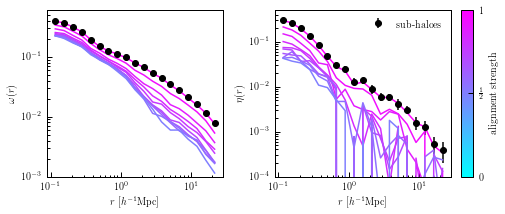

In [51]:
ps = np.linspace(1,0,10)
colors = np.linspace(1.0,0.5,len(ps))
colors = plt.cm.cool(colors)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7.0,3.3))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.3)

# ED
ax = ax1
l0 = ax.errorbar(rbin_centers, halo_omega, yerr=halo_omega_err,
                 fmt='o', color='black')
l1,  = ax.plot(rbin_centers, gal_omega_1,  '-', color=colors[0])
l2,  = ax.plot(rbin_centers, gal_omega_2,  '-', color=colors[1])
l3,  = ax.plot(rbin_centers, gal_omega_3,  '-', color=colors[2])
l4,  = ax.plot(rbin_centers, gal_omega_4,  '-', color=colors[3])
l5,  = ax.plot(rbin_centers, gal_omega_5,  '-', color=colors[4])
l6,  = ax.plot(rbin_centers, gal_omega_6,  '-', color=colors[5])
l7,  = ax.plot(rbin_centers, gal_omega_7,  '-', color=colors[6])
l8,  = ax.plot(rbin_centers, gal_omega_8,  '-', color=colors[7])
l9,  = ax.plot(rbin_centers, gal_omega_9,  '-', color=colors[8])
l10, = ax.plot(rbin_centers, gal_omega_10, '-', color=colors[9])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.001,0.6])

# EE
ax = ax2
l0 = ax.errorbar(rbin_centers, halo_eta, yerr=halo_eta_err, fmt='o',  color='black')
l1,  = ax.plot(rbin_centers, gal_eta_1,  '-', color=colors[0])
l2,  = ax.plot(rbin_centers, gal_eta_2,  '-', color=colors[1])
l3,  = ax.plot(rbin_centers, gal_eta_3,  '-', color=colors[2])
l4,  = ax.plot(rbin_centers, gal_eta_4,  '-', color=colors[3])
l5,  = ax.plot(rbin_centers, gal_eta_5,  '-', color=colors[4])
l6,  = ax.plot(rbin_centers, gal_eta_6,  '-', color=colors[5])
l7,  = ax.plot(rbin_centers, gal_eta_7,  '-', color=colors[6])
l8,  = ax.plot(rbin_centers, gal_eta_8,  '-', color=colors[7])
l9,  = ax.plot(rbin_centers, gal_eta_9,  '-', color=colors[8])
l10, = ax.plot(rbin_centers, gal_eta_10, '-', color=colors[9])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])

ax.legend([l0],['sub-haloes'], frameon=False, fontsize=10, loc='upper right')

sc = plt.scatter(ps*0.0, ps*0.0, c=ps, cmap = 'cool', vmin=0, vmax=1, s=0)
cax = fig.add_axes([0.92, 0.2, 0.025, 0.7]) 
cbar = fig.colorbar(sc, cax=cax, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['0', r'$\frac{1}{2}$', '1'])
cbar.ax.set_ylabel('alignment strength')

plt.show()

fig.savefig(figure_path + 'varying_central_alignment.pdf', dpi=300)

In [53]:
mus = np.linspace(0.99,0,10)
gal_omega_11, gal_eta_11   = calculate_ed_ee(0.99, mus[0], num_realizations=1)
gal_omega_22, gal_eta_22   = calculate_ed_ee(0.99, mus[1], num_realizations=1)
gal_omega_33, gal_eta_33   = calculate_ed_ee(0.99, mus[2], num_realizations=1)
gal_omega_44, gal_eta_44   = calculate_ed_ee(0.99, mus[3], num_realizations=1)
gal_omega_55, gal_eta_55   = calculate_ed_ee(0.99, mus[4], num_realizations=1)
gal_omega_66, gal_eta_66   = calculate_ed_ee(0.99, mus[5], num_realizations=1)
gal_omega_77, gal_eta_77   = calculate_ed_ee(0.99, mus[6], num_realizations=1)
gal_omega_88, gal_eta_88   = calculate_ed_ee(0.99, mus[7], num_realizations=1)
gal_omega_99, gal_eta_99   = calculate_ed_ee(0.99, mus[8], num_realizations=1)
gal_omega_100, gal_eta_100 = calculate_ed_ee(0.99, mus[9], num_realizations=1)

/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:420: UserWarning: 1033105 galaxies have a radial distance equal to zero (or infinity) from their host. These galaxies will be re-assigned random alignment vectors.
  warn(msg)
/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:428: UserWarning: `satellite_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)


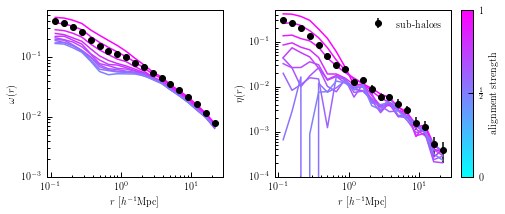

In [55]:
ps = np.linspace(1,0,10)
colors = np.linspace(1.0,0.5,len(ps))
colors = plt.cm.cool(colors)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(7.0,3.3))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.3)

# ED
ax = ax1
l0 = ax.errorbar(rbin_centers, halo_omega, yerr=halo_omega_err, fmt='o', color='black')
l1,  = ax.plot(rbin_centers, gal_omega_11,  '-', color=colors[0])
l2,  = ax.plot(rbin_centers, gal_omega_22,  '-', color=colors[1])
l3,  = ax.plot(rbin_centers, gal_omega_33,  '-', color=colors[2])
l4,  = ax.plot(rbin_centers, gal_omega_44,  '-', color=colors[3])
l5,  = ax.plot(rbin_centers, gal_omega_55,  '-', color=colors[4])
l6,  = ax.plot(rbin_centers, gal_omega_66,  '-', color=colors[5])
l7,  = ax.plot(rbin_centers, gal_omega_77,  '-', color=colors[6])
l8,  = ax.plot(rbin_centers, gal_omega_88,  '-', color=colors[7])
l9,  = ax.plot(rbin_centers, gal_omega_99,  '-', color=colors[8])
l10, = ax.plot(rbin_centers, gal_omega_100, '-', color=colors[9])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.001,0.6])

# EE
ax = ax2
l0 = ax.errorbar(rbin_centers, halo_eta, yerr=halo_eta_err, fmt='o',  color='black')
l1,  = ax.plot(rbin_centers, gal_eta_11,  '-', color=colors[0])
l2,  = ax.plot(rbin_centers, gal_eta_22,  '-', color=colors[1])
l3,  = ax.plot(rbin_centers, gal_eta_33,  '-', color=colors[2])
l4,  = ax.plot(rbin_centers, gal_eta_44,  '-', color=colors[3])
l5,  = ax.plot(rbin_centers, gal_eta_55,  '-', color=colors[4])
l6,  = ax.plot(rbin_centers, gal_eta_66,  '-', color=colors[5])
l7,  = ax.plot(rbin_centers, gal_eta_77,  '-', color=colors[6])
l8,  = ax.plot(rbin_centers, gal_eta_88,  '-', color=colors[7])
l9,  = ax.plot(rbin_centers, gal_eta_99,  '-', color=colors[8])
l10, = ax.plot(rbin_centers, gal_eta_100, '-', color=colors[9])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])

ax.legend([l0],['sub-haloes'], frameon=False, fontsize=10, loc='upper right')

sc = plt.scatter(ps*0.0, ps*0.0, c=ps, cmap = 'cool', vmin=0, vmax=1, s=0)
cax = fig.add_axes([0.92, 0.2, 0.025, 0.7]) 
cbar = fig.colorbar(sc, cax=cax, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['0', r'$\frac{1}{2}$', '1'])
cbar.ax.set_ylabel('alignment strength')

plt.show()

fig.savefig(figure_path + 'varying_satellite_alignment.pdf', dpi=300)